In [10]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional, Tuple

In [11]:
device = torch.device('cuda')

In [12]:
history_size = 96
predict_size = 96
hidden_size = 256
n_layers = 16
n_epoch = 3
lr = 0.0001

train_split = 4000

In [13]:
class RevIN(nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=True):
        """
        :param num_features: the number of features or channels
        :param eps: a value added for numerical stability
        :param affine: if True, RevIN has learnable affine parameters
        """
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        if self.affine:
            self._init_params()

    def forward(self, x, mode:str):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else: raise NotImplementedError
        return x

    def _init_params(self):
        # initialize RevIN params: (C,)
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim-1))
        self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps*self.eps)
        x = x * self.stdev
        x = x + self.mean
        return x

In [14]:
class LSTMCell(nn.Module):
    def __init__(self, input_size : int, hidden_size : int):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_lin = nn.Linear(hidden_size, 4 * hidden_size)
        self.input_lin = nn.Linear(input_size, 4 * hidden_size, bias=False)

    def forward(self, x, h_in, c_in):
        X = self.input_lin(x) + self.hidden_lin(h_in) # 입력과 은닉 상태를 선형 변환 후 더함
        i, f, g, o = X.chunk(4, dim=-1)

        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        g = torch.tanh(g)
        o = torch.sigmoid(o)

        c_next = c_in * f + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

In [15]:
class LSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, n_layers: int, use_RevIN: bool):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.use_Revin = use_RevIN
        self.cells = nn.ModuleList(
            [LSTMCell(input_size=input_size, hidden_size=hidden_size)] +
            [LSTMCell(input_size=hidden_size, hidden_size=hidden_size) for _ in range(n_layers - 1)]
        )
        self.linear = nn.Linear(self.hidden_size, 1)
        self.revin = RevIN(1)

    def forward(self, x: torch.Tensor, state: Optional[Tuple[torch.Tensor, torch.Tensor]] = None):
        batch_size, seq_len, _ = x.shape
        if self.use_Revin:
            x = self.revin(x, "norm")

        if state is None:
            h = [x.new_zeros(batch_size, self.hidden_size) for _ in range(self.n_layers)]
            c = [x.new_zeros(batch_size, self.hidden_size) for _ in range(self.n_layers)]
        else:
            h, c = state
            h, c = list(torch.unbind(h)), list(torch.unbind(c))

        outputs = []  # 각 time step의 출력을 담는 리스트
        for t in range(seq_len):
            inp = x[t, :].squeeze(-1)  # 각 시점의 입력
            for layer in range(self.n_layers):
                h[layer], c[layer] = self.cells[layer](inp, h[layer], c[layer])
                inp = h[layer]
            outputs.append(self.linear(h[-1]))  # 각 time step에서 마지막 layer의 hidden state를 사용해 예측
        outputs = torch.stack(outputs, dim=1).squeeze(0)  # 모든 time step의 예측을 쌓음

        if self.use_Revin:
            outputs = self.revin(outputs, "denorm").squeeze(0)

        h = torch.stack(h)
        c = torch.stack(c)

        return outputs[-predict_size:], (h, c)


In [16]:
data_csv = pd.read_csv("./cpu_mem/gc19_a.csv")
uni_data = data_csv['avgcpu']
#uni_data.index = data_csv['time'] # index로 매핑

In [17]:
def univariate_data(dataset, start_index, end_index, history_size, target_size, step, single_step=False):
    datas = []
    labels = []

    start_index = start_index + history_size

    if end_index == None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        datas.append(np.reshape(dataset[indices], (history_size,1)))

        if single_step: # 단기 예측
            labels.append(dataset[i + target_size])
        else: # 장기 예측
            labels.append(dataset[i:i + target_size])

    return np.array(datas), np.array(labels)

def multivariate_data(dataset, start_index, end_index, history_size, target_size, step, single_step=False):
    datas = []
    labels = []

    start_index = start_index + history_size

    if end_index == None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        datas.append(dataset[indices])

        if single_step: # 단기 예측
            labels.append(dataset[i + target_size])
        else: # 장기 예측
            labels.append(dataset[i:i + target_size])

    return np.array(datas), np.array(labels)

In [18]:
x_train_uni, y_train_uni = univariate_data(uni_data, 0, train_split, history_size, predict_size, 1, False)
x_test_uni, y_test_uni = univariate_data(uni_data, train_split, None, history_size, predict_size, 1, False)

In [19]:
def create_time_steps(length):
    if length >= 0:
        return range(0, length)
    else:
        return range(length, 0)

def show_plot(plot_data, delta, title):
    labels = ["history", "true future", "baseline", "mean"]
    marker = ["-", "r-", "g-", "yx"]
    time_steps = create_time_steps(-plot_data[0].shape[0])
    if delta: future = delta
    else: future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i == 3:
            plt.plot(1, plot_data[i], marker[i], label=labels[i])
        elif i:
            plt.plot(create_time_steps(x.shape[0]), plot_data[i], marker[i], label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])

    plt.legend()
    plt.axis('auto')
    plt.xlabel('time-steps')
    return plt  

In [21]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()
        self.mse = nn.MSELoss()
        self.eps = 1e-7

    def forward(self,y,y_hat):
        return torch.sqrt(self.mse(y,y_hat) + self.eps)

In [22]:
model = LSTM(input_size=predict_size, hidden_size=hidden_size, n_layers=n_layers, use_RevIN=True).to(device)
criterion = RMSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr)

In [23]:
# x_train_uni = DataLoader(dataset=torch.tensor(x_train_uni, dtype=torch.float), batch_size=100, num_workers=2, shuffle=False)
# y_train_uni = DataLoader(dataset=torch.tensor(y_train_uni, dtype=torch.float), batch_size=100, num_workers=2, shuffle=False)

x_train_uni = torch.tensor(x_train_uni, dtype=torch.float).to(device)
y_train_uni = torch.tensor(y_train_uni, dtype=torch.float).to(device)

x_train_uni.shape

torch.Size([3904, 96, 1])

In [24]:
def train(X, Y, model, criterion, optimizer, epoch):
    model.train()

    for ep in range(epoch):
        h, c = None, None  # 초기화
        for batch in range(0, len(X), predict_size):
            optimizer.zero_grad()
            data = X[batch: batch + predict_size]
            # 이전 배치에서 hidden state와 cell state가 있으면 detach()
            
            pred = model(data)
            # 손실 계산 및 역전파
            loss = criterion(Y[batch], pred[0])
            loss.backward()

            optimizer.step()

            # 100번째 배치마다 손실 출력
            if batch % 100 == 0:
                print(f"Epoch: {ep}; Batch: {batch}; Loss: {loss.item()};")
                show_plot([data[0, :].cpu(), Y[batch].cpu(), pred[0][:,-1].cpu().detach().squeeze(-1).numpy(), data[0, :].cpu().mean()], predict_size, "predict by lstm").show()


c:\Users\User\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([96, 96, 1])) that is different to the input size (torch.Size([96])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0; Batch: 0; Loss: 0.0358329676091671;


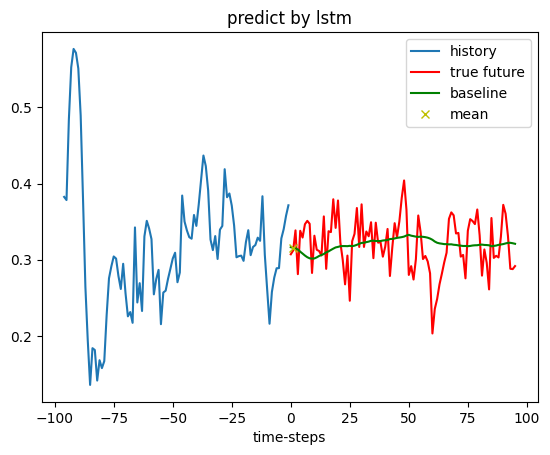

Epoch: 0; Batch: 100; Loss: 0.15948469936847687;


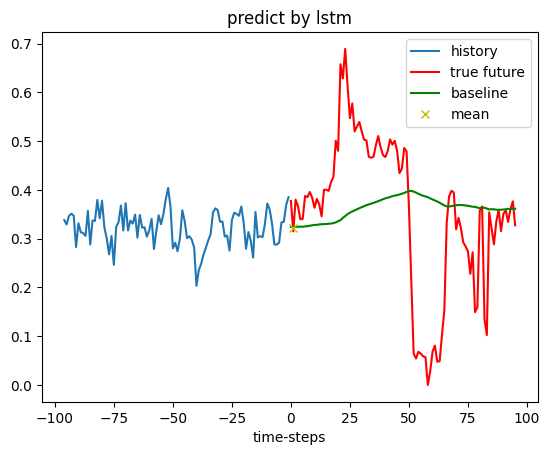

KeyboardInterrupt: 

In [25]:
train(x_train_uni.to(device), y_train_uni.to(device), model, criterion, optimizer, n_epoch)